<a href="https://colab.research.google.com/github/quantist25/Cheryvoicehub/blob/main/deep_qnn_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu


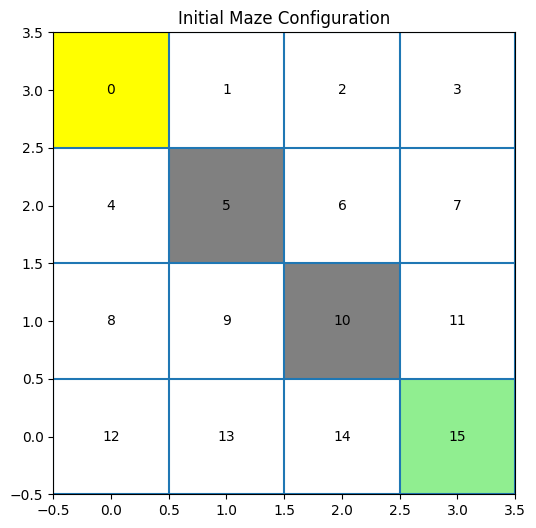

Training for 50 episodes...
Episode 0, Loss: 0.185738205909729
Episode 0, Loss: 0.185738205909729
Episode 0, Loss: 0.20807009935379028
Episode 0, Loss: 0.08452564477920532
Episode 0, Loss: 0.06789939105510712
Episode 0, Loss: 6.127660890342668e-05
Episode 0, Loss: 0.04304644837975502
Episode 0, Loss: 0.0008522198768332601
Episode 0, Loss: 0.034102294594049454
Episode 0, Loss: 0.034102294594049454
Episode 0, Loss: 0.025919737294316292
Episode 0, Loss: 0.008438806049525738
Episode 0, Loss: 0.008438806049525738
Episode 0, Loss: 0.0078043267130851746
Episode 0, Loss: 0.004227723926305771
Episode 0, Loss: 0.005254286807030439
Episode 0, Loss: 0.003598627168685198
Episode 0, Loss: 0.004661752842366695
Episode 0, Loss: 0.0003271514142397791
Episode 0, Loss: 0.010844788514077663
Episode 0, Loss: 0.0004429409164004028
Episode 0, Loss: 0.0004429409164004028
Episode 0, Loss: 0.0004429409164004028
Episode 0, Loss: 0.0007877828320488334
Episode 0, Loss: 0.0009449856588616967
Episode 0, Loss: 0.0009

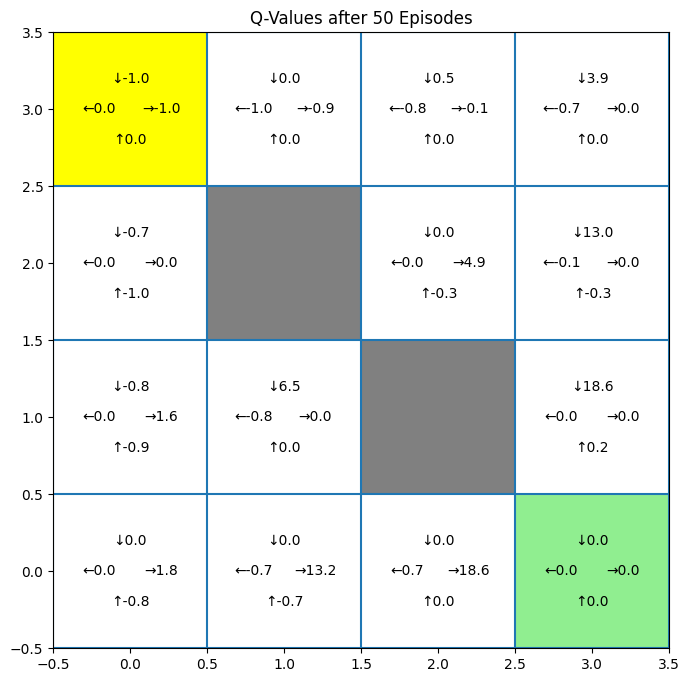

Training for 50 episodes...
Episode 50, Loss: 7.732149124145508
Episode 50, Loss: 7.732149124145508
Episode 50, Loss: 7.732149124145508
Episode 50, Loss: 12.930572509765625
Episode 51, Loss: 50.73919677734375
Episode 51, Loss: 50.73919677734375
Episode 51, Loss: 50.73919677734375
Episode 51, Loss: 50.73919677734375
Episode 51, Loss: 50.73919677734375
Episode 51, Loss: 16.737810134887695
Episode 51, Loss: 0.0026722364127635956
Episode 51, Loss: 0.0026722364127635956
Episode 51, Loss: 16.7374324798584
Episode 52, Loss: 48.28216552734375
Episode 52, Loss: 48.28216552734375
Episode 52, Loss: 48.28216552734375
Episode 52, Loss: 48.28216552734375
Episode 52, Loss: 8.385430335998535
Episode 52, Loss: 0.0010984415421262383
Episode 52, Loss: 0.0009602695354260504
Episode 52, Loss: 0.0009602695354260504
Episode 52, Loss: 0.0009602695354260504
Episode 52, Loss: 0.0009602695354260504
Episode 52, Loss: 0.0009602695354260504
Episode 52, Loss: 0.0009602695354260504
Episode 52, Loss: 8.90781307220459


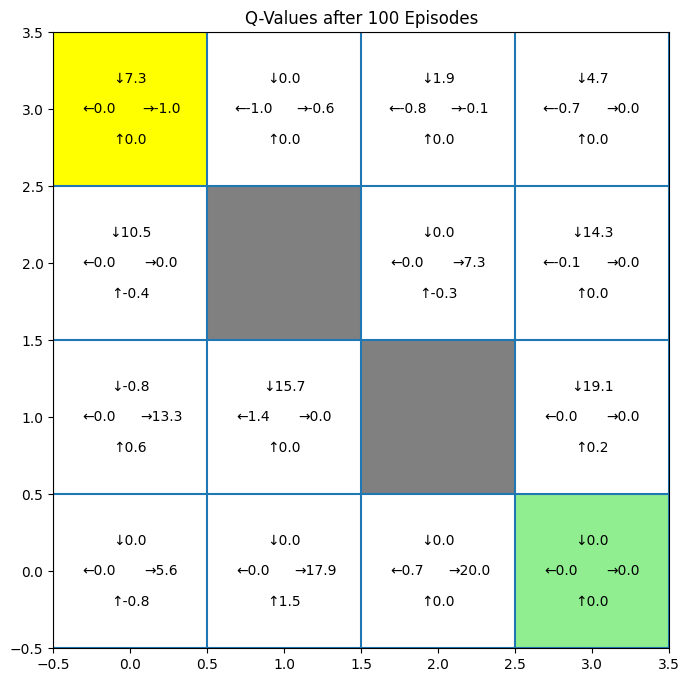

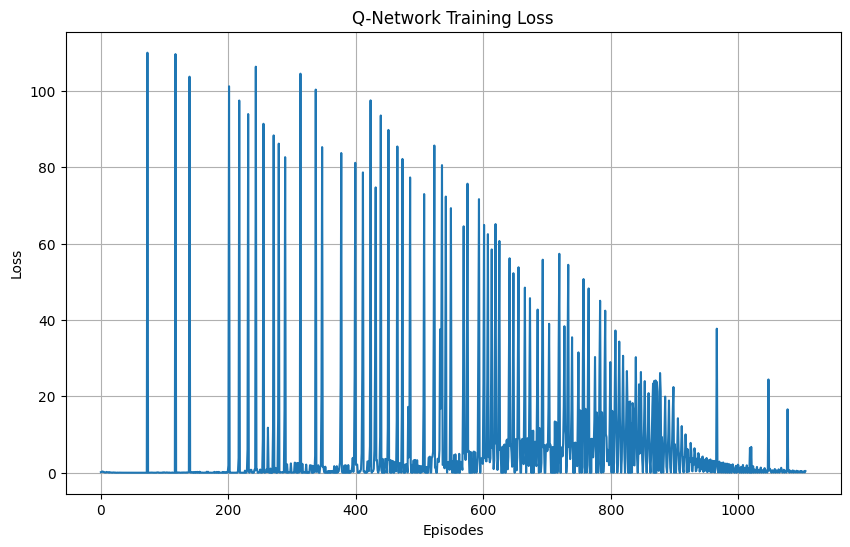

Comparing Q-values from Q-table and Neural Network:


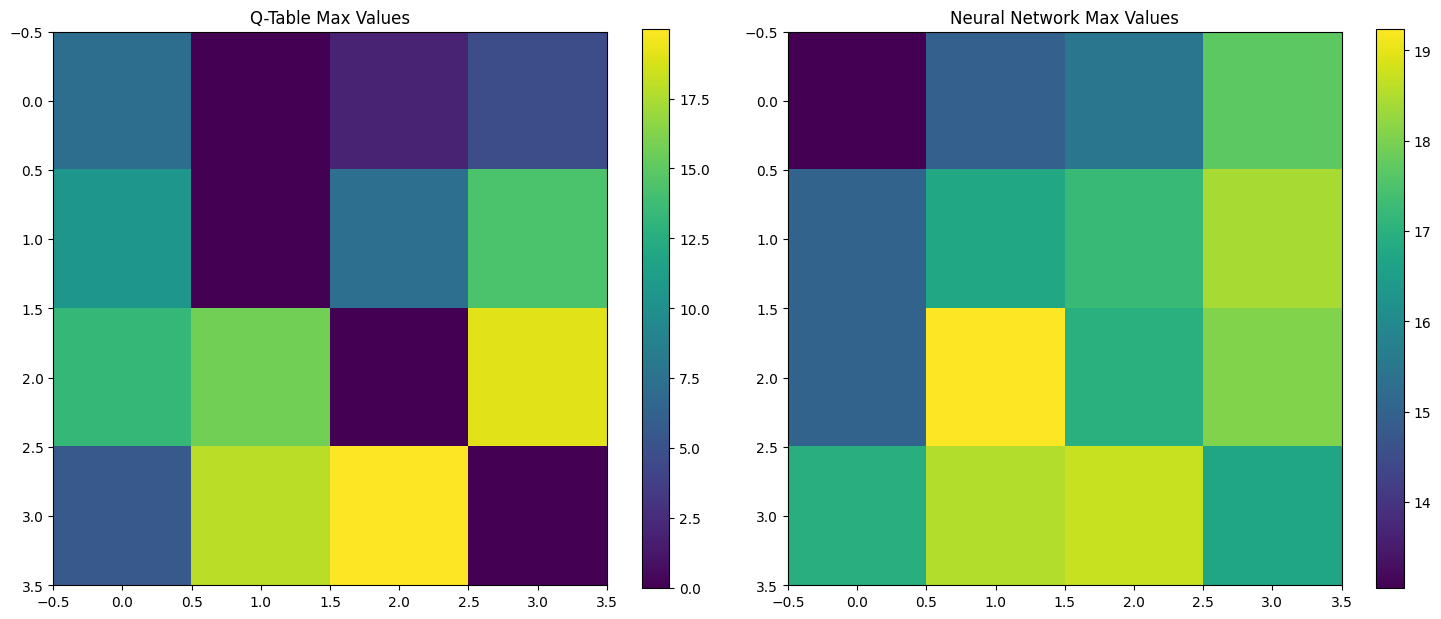

Path animation for episode 99 saved as episode_99_path.gif
Optimal path found with 6 steps.


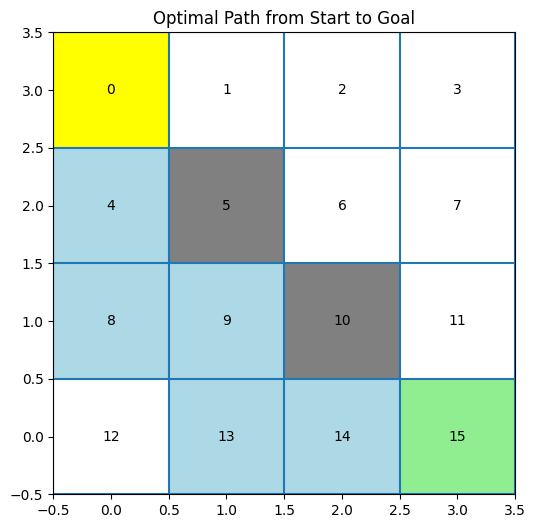

Creating animations of learning progress...
All visualizations completed!


In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from IPython.display import clear_output
import os
from PIL import Image
import seaborn as sns
from typing import Tuple, List, Dict

# Configure matplotlib
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['text.usetex'] = False  # Changed to False for easier Colab compatibility

# Create directories for animations
def create_directories():
    """Create directories for storing visualization results"""
    directories = [
        "q_approximation_images",
        "q_network_progress",
        "v_network_progress",
        "agent_path_animation"
    ]
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        # Clear existing files
        for file in os.listdir(directory):
            os.remove(os.path.join(directory, file))

# Helper function to create GIFs from image sequences
def create_gif(image_dir: str, output_filename: str, duration: int = 300):
    """Create a GIF from a sequence of images in the specified directory"""
    images = []
    image_files = os.listdir(image_dir)
    image_files.sort(key=lambda x: int(x.split("_")[1].split(".")[0]))
    for file in image_files:
        images.append(Image.open(os.path.join(image_dir, file)))
    if images:
        images[0].save(
            output_filename,
            save_all=True,
            append_images=images[1:],
            duration=duration,
            loop=0
        )

# Visualization functions
def array_index_to_matplot_coords(i: int, j: int, n_rows: int) -> Tuple[int, int]:
    """Converts array indices to matplotlib coordinates"""
    x = j
    y = n_rows - i - 1
    return x, y

def plot_matrix(
    M: np.ndarray,
    goal_coords: List[Tuple[int, int]] = [],
    wall_coords: List[Tuple[int, int]] = [],
    start_coords: List[Tuple[int, int]] = [],
    highlight_coords: List[Tuple[int, int]] = [],
    title: str = None,
    filename: str = None,
    figsize: Tuple[int, int] = (6, 6)
) -> None:
    """Plots a grid world as a matrix with colored cells for start, goal, walls, and agent position"""
    height, width = M.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect='equal')

    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # Color cells based on their type
            if (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            elif (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))
            elif (x, y) in highlight_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightblue'))

            # Add state number
            ax.annotate(str(M[x][y]), xy=(matplot_x, matplot_y), ha='center', va='center')

    # Set plot limits and grid lines
    offset = 0.5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)
    ax.hlines(y=np.arange(height+1) - offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    if filename:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

def plot_state_visits(
    S: np.ndarray,
    visit_dict: Dict[int, int],
    title: str = "State Visit Counts",
    filename: str = None,
    figsize: Tuple[int, int] = (6, 6)
):
    """Plot a heatmap showing how many times each state was visited"""
    n_rows, n_cols = S.shape
    V = np.zeros((n_rows, n_cols))

    for s, visits in visit_dict.items():
        s_index = np.where(S == s)
        if len(s_index[0]) > 0:  # Make sure the state exists in S
            row, col = s_index[0][0], s_index[1][0]
            V[row, col] = visits

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)

    sns.heatmap(V, cmap='Blues', annot=True, fmt='.0f', ax=ax)
    plt.title(title)

    if filename:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

def plot_Q_values(
    S: np.ndarray,
    Q: np.ndarray,
    goal_coords: List[Tuple[int, int]],
    wall_coords: List[Tuple[int, int]],
    start_coords: List[Tuple[int, int]],
    title: str,
    filename: str = None,
    figsize: Tuple[int, int] = (8, 8)
):
    """Plot the Q-values for each state and action"""
    height, width = S.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect='equal')

    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # Color cells based on their type
            if (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            elif (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))

            # Add Q-values for each action
            if (x, y) not in wall_coords:
                state = S[x, y]
                q_values = Q[state]
                ax.annotate(f'↑{q_values[0]:.1f}', xy=(matplot_x, matplot_y - 0.2), ha='center', va='center')
                ax.annotate(f'↓{q_values[1]:.1f}', xy=(matplot_x, matplot_y + 0.2), ha='center', va='center')
                ax.annotate(f'←{q_values[2]:.1f}', xy=(matplot_x - 0.2, matplot_y), ha='center', va='center')
                ax.annotate(f'→{q_values[3]:.1f}', xy=(matplot_x + 0.2, matplot_y), ha='center', va='center')

    # Set plot limits and grid lines
    offset = 0.5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)
    ax.hlines(y=np.arange(height+1) - offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    if filename:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

def plot_V_values(
    S: np.ndarray,
    Q: np.ndarray,
    goal_coords: List[Tuple[int, int]],
    wall_coords: List[Tuple[int, int]],
    start_coords: List[Tuple[int, int]],
    title: str,
    filename: str = None,
    figsize: Tuple[int, int] = (6, 6)
):
    """Plot the maximum Q-value (V-value) for each state with action direction"""
    height, width = S.shape
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, aspect='equal')

    for x in range(height):
        for y in range(width):
            matplot_x, matplot_y = array_index_to_matplot_coords(x, y, height)

            # Color cells based on type
            if (x, y) in wall_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='gray'))
            elif (x, y) in goal_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='lightgreen'))
            elif (x, y) in start_coords:
                ax.add_patch(matplotlib.patches.Rectangle((matplot_x - 0.5, matplot_y - 0.5), 1, 1, facecolor='yellow'))

            # Add max Q-value and best action arrow
            if (x, y) not in wall_coords:
                state = S[x, y]
                q_values = Q[state]
                v_value = max(q_values)
                best_action = np.argmax(q_values)

                ax.annotate(f'{v_value:.2f}', xy=(matplot_x, matplot_y), ha='center', va='center')

                # to Draw arrow for best action
                arrow_length = 0.3
                if best_action == 0:  # up
                    ax.arrow(matplot_x, matplot_y + 0.1, 0, arrow_length, head_width=0.05, head_length=0.05, fc='black', ec='black')
                elif best_action == 1:  # down
                    ax.arrow(matplot_x, matplot_y - 0.1, 0, -arrow_length, head_width=0.05, head_length=0.05, fc='black', ec='black')
                elif best_action == 2:  # left
                    ax.arrow(matplot_x - 0.1, matplot_y, -arrow_length, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')
                elif best_action == 3:  # right
                    ax.arrow(matplot_x + 0.1, matplot_y, arrow_length, 0, head_width=0.05, head_length=0.05, fc='black', ec='black')

    # Set plot limits and grid lines
    offset = 0.5
    ax.set_xlim(-offset, width - offset)
    ax.set_ylim(-offset, height - offset)
    ax.hlines(y=np.arange(height+1) - offset, xmin=-offset, xmax=width-offset)
    ax.vlines(x=np.arange(width+1) - offset, ymin=-offset, ymax=height-offset)

    plt.title(title)
    if filename:
        plt.savefig(filename)
        plt.close(fig)
    else:
        plt.show()

def plot_learning_curve(losses, title="Neural Network Training Loss", filename=None):
    """Plot the learning curve of the neural network training"""
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)

    if filename:
        plt.savefig(filename)
        plt.close()
    else:
        plt.show()

# Define the Q-Network architecture
class QNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# RL Agent class
class Agent:
    def __init__(
        self,
        nrow_maze: int = 4,
        ncol_maze: int = 4,
        actions: List[int] = [0, 1, 2, 3],  # up, down, left, right
        rewards: Dict[str, float] = {
            'step': -1,    # Small penalty for each step
            'wall': -5,    # Penalty for hitting wall
            'goal': 10,    # Reward for reaching goal
        },
        gamma: float = 0.95,  # Discount factor
        alpha: float = 0.1,   # Learning rate for Q-table
        epsilon: float = 0.2,  # Exploration rate
        epsilon_decay: float = 0.99,  # Rate at which epsilon decreases
        seed: int = 42,
        nn_learning_rate: float = 0.001,  # Learning rate for neural network
    ) -> None:
        self.nrow_maze = nrow_maze
        self.ncol_maze = ncol_maze
        self.actions = actions
        self.rewards = rewards
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.seed = seed

        # Set up random number generator
        self.random_generator = np.random.default_rng(seed)

        # Initialize state space, Q-table, and neural network
        self.init_state_space()
        self.init_Q_table()

        # Default start and goal states
        self.start_state = 0
        self.goal_state = nrow_maze * ncol_maze - 1

        # Initialize action details
        self.past_action = None
        self.past_state = None
        self.action_name_dict = {
            0: 'up',
            1: 'down',
            2: 'left',
            3: 'right',
        }

        # Tracking variables
        self.num_goal_reached = 0
        self.state_visit_counter = {}
        self.state_visit_paths = {}
        self.current_episode = 0
        self.losses = []

        # Initialize Neural Network
        input_size = self.nrow_maze * self.ncol_maze + 1  # One-hot encoded state + goal info
        hidden_size1 = 64
        hidden_size2 = 32
        output_size = len(actions)

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.q_network = QNetwork(input_size, hidden_size1, hidden_size2, output_size).to(self.device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=nn_learning_rate)
        self.loss_fn = nn.MSELoss()

    def init_state_space(self):
        """Initialize the state space as a 2D grid"""
        self.S = np.arange(0, self.nrow_maze * self.ncol_maze).reshape(self.nrow_maze, self.ncol_maze)

    def init_Q_table(self):
        """Initialize the Q-table with zeros"""
        self.Q = np.zeros((self.S.size, len(self.actions)))

    def init_reward_dict(self):
        """Initialize the reward dictionary for all states"""
        self.reward_dict = {s: self.rewards['step'] for s in self.S.flatten()}
        self.reward_dict[self.goal_state] = self.rewards['goal']
        for wall_state in self.wall_states:
            self.reward_dict[wall_state] = self.rewards['wall']

    def init_maze(self):
        """Initialize the maze with walls, start and goal positions"""
        # Place walls randomly in central positions
        possible_wall_positions = [5, 6, 9, 10]  # Central positions in a 4x4 grid
        wall_states = self.random_generator.choice(
            possible_wall_positions,
            size=2,
            replace=False
        )

        # Get coordinates of walls
        wall_coords = [self.get_state_coords(s) for s in wall_states]

        # Set start and goal states
        self.start_state = 0  # Top-left corner
        self.goal_state = 15  # Bottom-right corner

        start_coords = self.get_state_coords(self.start_state)
        goal_coords = self.get_state_coords(self.goal_state)

        # Store maze information
        self.wall_coords = wall_coords
        self.start_coords = [start_coords]
        self.goal_coords = [goal_coords]
        self.wall_states = wall_states

        # Initialize reward dictionary
        self.init_reward_dict()

        # Initialize agent position
        self.init_agent()

    def get_state_index(self, row: int, col: int) -> int:
        """Convert row and column coordinates to state index"""
        if row < 0 or row >= self.nrow_maze or col < 0 or col >= self.ncol_maze:
            return -1
        else:
            return self.S[row][col]

    def get_state_coords(self, s) -> Tuple[int, int]:
        """Convert state index to row and column coordinates"""
        s_index = np.where(self.S == s)
        if len(s_index[0]) == 0:
            return -1, -1
        return s_index[0][0], s_index[1][0]

    def get_random_action(self) -> int:
        """Select a random action"""
        return self.random_generator.choice(self.actions)

    def argmax(self, q_values: np.ndarray) -> int:
        """Find the action with the highest Q-value, breaking ties randomly"""
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []
            if q_values[i] == top:
                ties.append(i)

        return self.random_generator.choice(ties)

    def get_greedy_action(self, state: int) -> int:
        """Select the action with the highest Q-value for a given state"""
        q_values = self.Q[state]
        return self.argmax(q_values)

    def get_epsilon_greedy_action(self, state: int) -> int:
        """Select an action using epsilon-greedy policy"""
        if self.random_generator.random() < self.epsilon:
            return self.get_random_action()
        else:
            return self.get_greedy_action(state)

    def log_agent_move(self, state: int):
        """Record agent's movement path"""
        if self.state_visit_paths.get(self.current_episode, None) is None:
            self.state_visit_paths[self.current_episode] = [state]
        else:
            self.state_visit_paths[self.current_episode].append(state)

    def update_Q_table(self, new_state: int):
        """Update Q-table using Q-learning update rule"""
        old_q = self.Q[self.past_state, self.past_action]
        next_max = np.max(self.Q[new_state])
        reward = self.reward_dict[new_state]

        # Q-learning update formula
        new_q = old_q + self.alpha * (reward + self.gamma * next_max - old_q)
        self.Q[self.past_state, self.past_action] = new_q

    def update_Q_network(self, new_state: int):
        """Update Q-network using experience from Q-table"""
        # Convert state to one-hot encoding plus goal state information
        state_tensor = self.state_to_tensor(self.past_state)

        # Get current Q-values from network
        self.q_network.eval()
        with torch.no_grad():
            current_q_values = self.q_network(state_tensor)

        # Create target Q-values
        target_q_values = current_q_values.clone().detach()

        # Calculate target Q-value for the taken action
        reward = self.reward_dict[new_state]

        if new_state == self.goal_state:
            # Terminal state
            target_q_values[self.past_action] = reward
        else:
            # Use Q-table's next max value as target
            next_max = np.max(self.Q[new_state])
            target_q_values[self.past_action] = reward + self.gamma * next_max

        # Train the network
        self.q_network.train()
        self.optimizer.zero_grad()

        # Forward pass
        predicted_q_values = self.q_network(state_tensor)

        # Compute loss
        loss = self.loss_fn(predicted_q_values, target_q_values)

        # Backward pass and optimization
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def state_to_tensor(self, state: int) -> torch.Tensor:
        """Convert state index to input tensor for neural network"""
        # Create a one-hot encoding for the state
        state_encoding = np.zeros(self.nrow_maze * self.ncol_maze + 1)
        state_encoding[state] = 1

        # Add goal state information
        state_encoding[-1] = self.goal_state

        return torch.FloatTensor(state_encoding).to(self.device)

    def get_network_q_values(self, state: int) -> np.ndarray:
        """Get Q-values from the neural network for a state"""
        state_tensor = self.state_to_tensor(state)

        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state_tensor).cpu().numpy()

        return q_values

    def get_next_state(self, s: int, action: int) -> Tuple[int, bool]:
        """Get the next state after taking an action from state s"""
        s_row, s_col = self.get_state_coords(s)
        reached_terminal = False
        next_state = -1

        # Determine next state based on action
        if action == 0:  # up
            next_state = self.get_state_index(s_row - 1, s_col)
        elif action == 1:  # down
            next_state = self.get_state_index(s_row + 1, s_col)
        elif action == 2:  # left
            next_state = self.get_state_index(s_row, s_col - 1)
        elif action == 3:  # right
            next_state = self.get_state_index(s_row, s_col + 1)

        # Check if the next state is valid
        if (next_state == -1) or (next_state in self.wall_states):
            return s, reached_terminal  # Stay in the same state

        # Check if goal state reached
        if next_state == self.goal_state:
            self.num_goal_reached += 1
            reached_terminal = True

        return next_state, reached_terminal

    def init_agent(self):
        """Initialize agent at start state"""
        self.past_state = self.start_state
        self.past_action = self.get_epsilon_greedy_action(self.past_state)
        self.num_goal_reached = 0

    def terminal_step(self, new_state: int):
        """Handle reaching terminal state"""
        # Update Q-table and neural network
        self.update_Q_table(new_state)
        loss = self.update_Q_network(new_state)
        self.losses.append(loss)

        # Reset agent position
        self.past_state = self.start_state
        self.past_action = self.get_epsilon_greedy_action(self.past_state)

        # Update epsilon (exploration rate)
        self.epsilon = max(0.01, self.epsilon * self.epsilon_decay)

        # Increment episode counter
        self.current_episode += 1

    def move_agent(self):
        """Move the agent according to the current policy"""
        # this section is to Get next state and check if terminal
        next_state, reached_terminal = self.get_next_state(self.past_state, self.past_action)

        # Record path
        self.log_agent_move(next_state)

        # Update visit count for this state
        if next_state in self.state_visit_counter:
            self.state_visit_counter[next_state] += 1
        else:
            self.state_visit_counter[next_state] = 1

        if not reached_terminal:
            # Continue episode
            if self.past_state != next_state:  # Only update if state changed
                self.update_Q_table(next_state)
                loss = self.update_Q_network(next_state)
                self.losses.append(loss)

            # Update current state and action
            self.past_state = next_state
            self.past_action = self.get_epsilon_greedy_action(self.past_state)
        else:
            # Terminal state reached
            self.terminal_step(next_state)

    def train_episodes(self, num_episodes: int, save_freq: int = 5):
        """Train the agent for a specified number of episodes"""
        print(f"Training for {num_episodes} episodes...")
        end_episode = self.current_episode + num_episodes

        progress_images_dir_Q = "q_network_progress"
        progress_images_dir_V = "v_network_progress"
        os.makedirs(progress_images_dir_Q, exist_ok=True)
        os.makedirs(progress_images_dir_V, exist_ok=True)

        episode_count = 0
        while self.current_episode < end_episode:
            episode_count += 1
            self.move_agent()

            # Save visualization periodically
            if episode_count % save_freq == 0 or self.current_episode == end_episode - 1:
                print(f"Episode {self.current_episode}, Loss: {self.losses[-1] if self.losses else 'N/A'}")

                # Save Q-table visualization
                q_filename = f"{progress_images_dir_Q}/episode_{self.current_episode}.png"
                plot_Q_values(
                    self.S, self.Q, self.goal_coords, self.wall_coords,
                    self.start_coords, f"Q-Table at Episode {self.current_episode}",
                    filename=q_filename
                )

                # Save V-table visualization
                v_filename = f"{progress_images_dir_V}/episode_{self.current_episode}.png"
                plot_V_values(
                    self.S, self.Q, self.goal_coords, self.wall_coords,
                    self.start_coords, f"V-Values at Episode {self.current_episode}",
                    filename=v_filename
                )

        print(f"Training completed. Agent reached goal {self.num_goal_reached} times.")

    def compare_q_values(self):
        """Compare Q-values from Q-table and neural network"""
        print("Comparing Q-values from Q-table and Neural Network:")

        fig, ax = plt.subplots(1, 2, figsize=(15, 6))

        # Q-table values as matrix
        q_mat = np.zeros((self.nrow_maze, self.ncol_maze))
        for i in range(self.nrow_maze):
            for j in range(self.ncol_maze):
                state = self.S[i, j]
                q_mat[i, j] = np.max(self.Q[state])

        # Neural network values as matrix
        nn_mat = np.zeros((self.nrow_maze, self.ncol_maze))
        for i in range(self.nrow_maze):
            for j in range(self.ncol_maze):
                state = self.S[i, j]
                nn_mat[i, j] = np.max(self.get_network_q_values(state))

        # Plot Q-table values
        im1 = ax[0].imshow(q_mat, cmap='viridis')
        ax[0].set_title('Q-Table Max Values')
        fig.colorbar(im1, ax=ax[0])

        # Plot neural network values
        im2 = ax[1].imshow(nn_mat, cmap='viridis')
        ax[1].set_title('Neural Network Max Values')
        fig.colorbar(im2, ax=ax[1])

        plt.tight_layout()
        plt.savefig('q_value_comparison.png')
        plt.show()

    def visualize_agent_path(self, episode_num=None):
        """Visualize agent's path for a specific episode or the last episode"""
        # If no episode number is specified, use the most recent one
        if episode_num is None:
            episode_num = self.current_episode - 1

        # Check if the episode exists in the recorded paths
        if episode_num not in self.state_visit_paths:
            print(f"No path recorded for episode {episode_num}")
            return

        # Get the path for the specified episode
        episode_path = self.state_visit_paths[episode_num]
        episode_path_coords = [self.get_state_coords(state) for state in episode_path]

        # Directory for animation frames
        path_dir = "agent_path_animation"
        os.makedirs(path_dir, exist_ok=True)

        # Clear existing files
        for file in os.listdir(path_dir):
            os.remove(os.path.join(path_dir, file))

        # Generate an image for each step in the path
        for i, state_coords in enumerate(episode_path_coords):
            filename = f"{path_dir}/step_{i}.png"
            plot_matrix(
                self.S,
                goal_coords=self.goal_coords,
                wall_coords=self.wall_coords,
                start_coords=self.start_coords,
                highlight_coords=[state_coords],
                title=f"Episode {episode_num}, Step {i}",
                filename=filename
            )

        # Create a GIF from the images
        create_gif(path_dir, f"episode_{episode_num}_path.gif")
        print(f"Path animation for episode {episode_num} saved as episode_{episode_num}_path.gif")

    def create_policy(self):
        """Create a deterministic policy from the Q-table"""
        policy = {}
        for state in range(self.S.size):
            policy[state] = self.argmax(self.Q[state])
        return policy

    def get_optimal_path(self):
        """Determine the optimal path from start to goal using the learned policy"""
        # Get the deterministic policy
        policy = self.create_policy()

        # Initialize path
        optimal_path = [self.start_state]
        current_state = self.start_state

        # Safety counter to prevent infinite loops
        max_steps = self.nrow_maze * self.ncol_maze * 2
        step_count = 0

        # Follow the policy until goal is reached or max steps is exceeded
        while current_state != self.goal_state and step_count < max_steps:
            # Get the action from policy
            action = policy[current_state]

            # Take the action
            next_state, _ = self.get_next_state(current_state, action)

            # If we hit a wall, we'll stay in the same state
            if next_state != current_state:
                # Add next state to path
                optimal_path.append(next_state)
                current_state = next_state
            else:
                # If we're stuck (e.g., policy leads to a wall), break
                print("Warning: Policy leads to a dead end.")
                break

            step_count += 1

        # Check if we reached the goal
        if current_state == self.goal_state:
            print(f"Optimal path found with {len(optimal_path)-1} steps.")
            return optimal_path
        else:
            print("Failed to find optimal path to goal.")
            return None

# Main execution
if __name__ == "__main__":
    # Create directories for saving results
    create_directories()

    # Create and initialize agent
    agent = Agent(
        nrow_maze=4,
        ncol_maze=4,
        rewards={'step': -1, 'wall': -5, 'goal': 20},
        gamma=0.95,
        alpha=0.1,
        epsilon=0.2,
        epsilon_decay=0.995,
        seed=42,
        nn_learning_rate=0.001
    )

    # Initialize maze with walls
    agent.init_maze()

    # Display the initial maze
    plot_matrix(
        agent.S,
        goal_coords=agent.goal_coords,
        wall_coords=agent.wall_coords,
        start_coords=agent.start_coords,
        title="Initial Maze Configuration"
    )

    # Training phase 1: Train for 50 episodes
    agent.train_episodes(50, save_freq=10)

    # Display Q-values after initial training
    plot_Q_values(
        agent.S, agent.Q, agent.goal_coords, agent.wall_coords,
        agent.start_coords, "Q-Values after 50 Episodes"
    )

    # Training phase 2: Continue training for another 50 episodes
    agent.train_episodes(50, save_freq=10)

        # Display Q-values after additional training
    plot_Q_values(
        agent.S, agent.Q, agent.goal_coords, agent.wall_coords,
        agent.start_coords, "Q-Values after 100 Episodes"
    )

        # Plot learning curve
    plot_learning_curve(agent.losses, "Q-Network Training Loss")

    # Compare Q-values from table and neural network
    agent.compare_q_values()

    # Visualize the agent's path for the last episode
    agent.visualize_agent_path()

    # This section is to Get my optimal path visualize the optimal path
    optimal_path = agent.get_optimal_path()
    if optimal_path:
        optimal_path_coords = [agent.get_state_coords(state) for state in optimal_path]
        plot_matrix(
            agent.S,
            goal_coords=agent.goal_coords,
            wall_coords=agent.wall_coords,
            start_coords=agent.start_coords,
            highlight_coords=optimal_path_coords[1:-1],  # Exclude start and goal
            title="Optimal Path from Start to Goal"
        )

    # Create GIFs from saved progress images
    print("Creating animations of learning progress...")
    create_gif("q_network_progress", "q_table_learning_progress.gif", duration=400)
    create_gif("v_network_progress", "v_table_learning_progress.gif", duration=400)

    print("All visualizations completed!")